Here, we redefine the aimc value based on the original Park & Choi (2005) definition of the early type galaxies in the color - color-gradient space:

\begin{equation}
  \text{aimc} = \tan^{-1} \left( \frac{-\Delta (g-i) + 0.260}{(u-r) - 1.343} \right) + 90^\circ
\end{equation}

We redefine the $c_{inv}$ cut based on skew-normal fits to the $c_{inv}$ distributions for each magnitude bin.

In [38]:
from astropy.table import Table, vstack

import numpy as np

import matplotlib.pyplot as plt

#from aimc_SDSS import SDSS_aimc

## Import Data

In [2]:
#galaxy_filename = '../../Data/dwarf_voidstatus_P-MJD-F_MPAJHU_ZdustOS_stellarMass_BPT_SFR_NSA_ALFALFA_HI70.txt'
#galaxy_filename = '../../Data/kias1033_5_P-MJD-F_MPAJHU_ZdustOS_stellarMass_BPT_SFR_NSA_correctVflag.txt'
#galaxy_filename = '/Users/kellydouglass/Documents/Drexel/Research/Data/kias1033_5_P-MJD-F_MPAJHU_ZdustOS_stellarMass_BPT_SFR_NSA_correctVflag.txt'
galaxy_filename = '/Users/kellydouglass/Documents/Research/data/NSA_v1_0_1_VAGC.fits'

#galaxies = Table.read(galaxy_filename, format='ascii.commented_header')
galaxies = Table.read(galaxy_filename, format='fits')

## Replace all invalid color, color gradients with NaNs

In [3]:
galaxies['cd'][galaxies['cd'] == -99] = np.nan
galaxies['u_r_KIAS'][galaxies['u_r_KIAS'] == -99] = np.nan

# Calculate aimc

In [18]:
def SDSS_aimc_vertical(u_r, Dg_i):

    # Formula derived by Greg Zengilowski
    aimc = np.arctan2(-Dg_i + 0.260, u_r - 1.343) + 0.5*np.pi

    # Convert from radians to degrees
    aimc = aimc*180/np.pi

    # Shift to 0-360
    aimc[aimc < 0] += 360

    return aimc

In [19]:
galaxies['my_aimc'] = SDSS_aimc_vertical(galaxies['u_r_KIAS'], galaxies['cd'])

## Compare to original aimc values

**Note:** This should be just $90^\circ$ off from the original aimc values.

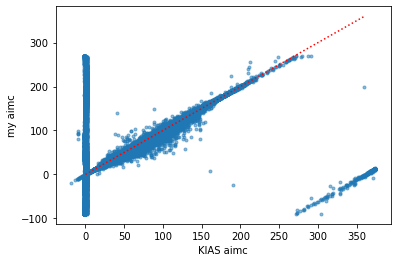

In [20]:
plt.figure()

plt.plot(galaxies['aimc'], galaxies['my_aimc'] - 90., '.', alpha=0.5)

plt.plot([0, 360], [0, 360], 'r:')

plt.xlabel('KIAS aimc')
plt.ylabel('my aimc');

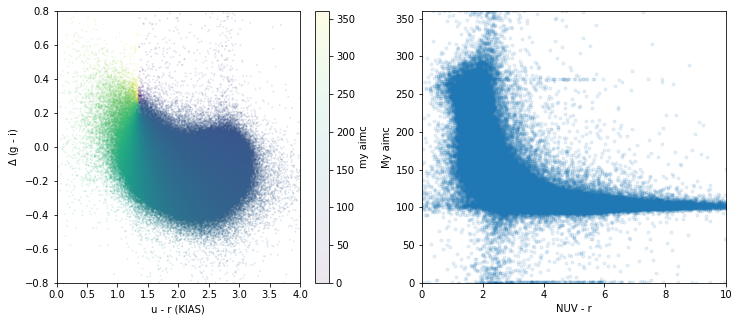

In [21]:
plt.figure(figsize=(12,5))



plt.subplot(121)

plt.scatter(galaxies['u_r_KIAS'], galaxies['cd'], s=1, c=galaxies['my_aimc'], alpha=0.1)

cbar = plt.colorbar()
cbar.ax.set_ylabel('my aimc')

plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')

plt.axis([0, 4, -0.8, 0.8])



plt.subplot(122)

plt.plot(galaxies['NUV_r'], galaxies['my_aimc'], '.', alpha=0.1)

#plt.hlines([45, 275], 0, 10, colors='r', linestyle='dotted')

#plt.vlines(5, 0, 165, colors='g', linestyle='dashed')

plt.axis([0, 10, 0, 360])

plt.xlabel('NUV - r')
plt.ylabel('My aimc');

# Define the GV

Split the galaxies up based on their location in the color - color gradient space (based on Park & Choi 2005 and Choi et al. 2010), their inverse concentration index, and their `SDSS_aimc_vertical` value.

* RS: normal early-type galaxies
* GV: 
  * blue early-type galaxies
  * normal late-type galaxies within the bounds of early-types with `conx1` > some value
  * normal late-type galaxies with `my_aimc` < 110
* BC: normal late-type galaxies with `my_aimc` > 110

#### Magnitude bins

In [22]:
boolean_14p5_16 = galaxies['prmag'] < 16
boolean_16_16p5 = np.logical_and(galaxies['prmag'] >= 16, galaxies['prmag'] < 16.5)
boolean_16p5_17 = np.logical_and(galaxies['prmag'] >= 16.5, galaxies['prmag'] < 17)
boolean_17_17p5 = galaxies['prmag'] >= 17

### Define the `conx1` limit as the intersection of the skew-normal distribution sum

\begin{equation}
  f(x; \alpha, \mu_\alpha, \sigma_\alpha, \xi_\alpha, \beta, \mu_\beta, \sigma_\beta, \xi_\beta) = \alpha \phi(z_\alpha) \Phi(\xi_\alpha z_\alpha) + \beta \phi(z_\beta) \Phi(\xi_\beta z_\beta)
\end{equation}

where $z = (x - \mu)/\sigma$, $\phi$ is the standard normal distribution, and $\Phi$ is the standard normal CDF.

In [23]:
from skewNorms_fit import skewNorms2, skewNorms2_fit, skewNorms2_diff

from scipy.stats import skewnorm

In [24]:
cinv_bins = np.arange(0.2, 0.6, 0.005)
cinv_centers = 0.5*(cinv_bins[1:] + cinv_bins[:-1])

##### Brightest galaxies

In [25]:
param_bounds = [[10., 3000.], # a ......... skew normal 1 amplitude
                [0.25, 0.35], # mu_a ...... skew normal 1 mean
                [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                [-30., 30.],  # skew_a .... skew normal 1 skew
                [1., 1000.],  # b ......... skew normal 2 amplitude
                [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                [-20., 20.]]  # skew_b .... skew normal 2 skew

dist_bright,_ = np.histogram(galaxies['conx1'][boolean_14p5_16], bins=cinv_bins)

bestfit = skewNorms2_fit(cinv_centers, dist_bright, param_bounds)

print(bestfit)

      fun: 482.4297263984278
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00055138,  0.48125344, -0.25145823,  0.00228511, -0.00098339,
       -0.13390604,  0.05477432, -0.00054001])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2232
      nit: 163
     njev: 248
   status: 0
  success: True
        x: array([ 1.67289135e+02,  2.90195162e-01,  5.05803504e-02,  5.30650237e+00,
        1.61267940e+02,  5.07802273e-01,  8.55862669e-02, -2.12272672e+00])


##### $16 < m_r < 16.5$

In [26]:
param_bounds = [[10., 3000.], # a ......... skew normal 1 amplitude
                [0.25, 0.35], # mu_a ...... skew normal 1 mean
                [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                [-30., 30.],  # skew_a .... skew normal 1 skew
                [1., 1000.],  # b ......... skew normal 2 amplitude
                [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                [-20., 20.]]  # skew_b .... skew normal 2 skew

dist_16_16p5,_ = np.histogram(galaxies['conx1'][boolean_16_16p5], bins=cinv_bins)

bestfit_16_16p5 = skewNorms2_fit(cinv_centers, dist_16_16p5, param_bounds)

print(bestfit_16_16p5)

      fun: 423.09101639063385
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.82120485e-05, -5.88283911e-01, -1.86230409e-01, -9.20863391e-04,
       -3.75166267e-04, -1.02926378e-01,  5.23488098e-01,  2.22826203e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1962
      nit: 148
     njev: 218
   status: 0
  success: True
        x: array([ 1.61873112e+02,  2.93497586e-01,  5.71402732e-02,  5.71129917e+00,
        1.43937857e+02,  5.10641592e-01,  8.03041559e-02, -2.10361751e+00])


##### $16.5 < m_r < 17$

In [27]:
param_bounds_16p5_17 = [[10., 3000.], # a ......... skew normal 1 amplitude
                        [0.25, 0.35], # mu_a ...... skew normal 1 mean
                        [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                        [-30., 30.],  # skew_a .... skew normal 1 skew
                        [1., 1000.],  # b ......... skew normal 2 amplitude
                        [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                        [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                        [0., 20.]]    # skew_b .... skew normal 2 skew

dist_16p5_17,_ = np.histogram(galaxies['conx1'][boolean_16p5_17], bins=cinv_bins)

bestfit_16p5_17 = skewNorms2_fit(cinv_centers, dist_16p5_17, param_bounds_16p5_17)

print(bestfit_16p5_17)

      fun: 748.6066782589606
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.01181205e-03,  8.23740721e-01,  1.76778485e+00, -1.34150469e-02,
       -1.44382169e-03, -2.20013590e+00,  4.83692020e-01, -7.90578270e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1431
      nit: 101
     njev: 159
   status: 0
  success: True
        x: array([3.25091892e+02, 2.97944633e-01, 7.16966032e-02, 5.27256664e+00,
       2.05391771e+02, 4.70930237e-01, 4.32690404e-02, 6.58285703e-09])


##### Faint galaxies

In [28]:
param_bounds_faint = [[10., 3000.], # a ......... skew normal 1 amplitude
                      [0.25, 0.4],  # mu_a ...... skew normal 1 mean
                      [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                      [-30., 30.],  # skew_a .... skew normal 1 skew
                      [1., 1000.],  # b ......... skew normal 2 amplitude
                      [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                      [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                      [-20., 20.]]  # skew_b .... skew normal 2 skew

dist_faint,_ = np.histogram(galaxies['conx1'][boolean_17_17p5], bins=cinv_bins)

bestfit_faint = skewNorms2_fit(cinv_centers, dist_faint, param_bounds_faint)

print(bestfit_faint)

      fun: 387.37301404477887
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.55359762e-03,  3.73938747e+00, -5.81080144e+00,  3.25712792e-02,
       -8.02628438e-03, -9.62483564e+00,  8.39554560e-01, -5.04485345e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1179
      nit: 99
     njev: 131
   status: 0
  success: True
        x: array([ 7.56082444e+02,  3.06070947e-01,  8.02211463e-02,  5.15715280e+00,
        6.00856752e+02,  5.18453873e-01,  7.76568865e-02, -2.40250674e+00])


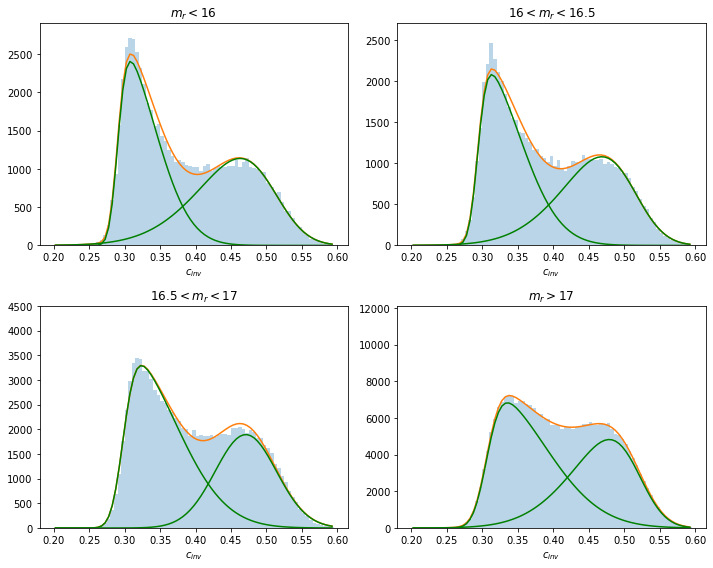

In [29]:
plt.figure(figsize=(10,8), tight_layout=True)

################################################################################
# Brightest galaxies
#-------------------------------------------------------------------------------
plt.subplot(221)

plt.hist(galaxies['conx1'][boolean_14p5_16], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit.x[0]*skewnorm.pdf(cinv_centers, bestfit.x[3], loc=bestfit.x[1], scale=bestfit.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit.x[4]*skewnorm.pdf(cinv_centers, bestfit.x[7], loc=bestfit.x[5], scale=bestfit.x[6]), 
        'g')

#plt.plot(cinv_centers,
#         bestfit.x[0]*norm.pdf(cinv_centers, loc=bestfit.x[1], scale=bestfit.x[2]), 
#         'r')
#plt.vlines(bestfit.x[1] + 2*bestfit.x[2], 0, 3000, colors='r', linestyle='dotted')

plt.ylim(ymax=2900)

plt.title('$m_r < 16$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16 < mr < 16.5
#-------------------------------------------------------------------------------
plt.subplot(222)

plt.hist(galaxies['conx1'][boolean_16_16p5], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_16_16p5.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_16_16p5.x[0]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16_16p5.x[3], 
                                           loc=bestfit_16_16p5.x[1], 
                                           scale=bestfit_16_16p5.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_16_16p5.x[4]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16_16p5.x[7], 
                                           loc=bestfit_16_16p5.x[5], 
                                           scale=bestfit_16_16p5.x[6]), 
        'g')

#plt.vlines(bestfit_16_16p5.x[1] + 2*bestfit_16_16p5.x[2], 
#           0, 3000, colors='r', linestyle='dotted')

plt.ylim(ymax=2700)

plt.title('$16 < m_r < 16.5$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16.5 < mr < 17
#-------------------------------------------------------------------------------
plt.subplot(223)

plt.hist(galaxies['conx1'][boolean_16p5_17], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_16p5_17.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_16p5_17.x[0]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16p5_17.x[3], 
                                           loc=bestfit_16p5_17.x[1], 
                                           scale=bestfit_16p5_17.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_16p5_17.x[4]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16p5_17.x[7], 
                                           loc=bestfit_16p5_17.x[5], 
                                           scale=bestfit_16p5_17.x[6]), 
        'g')

#plt.vlines(bestfit_16p5_17.x[1] + 2*bestfit_16p5_17.x[2], 
#           0, 4500, colors='r', linestyle='dotted')

plt.ylim(ymax=4500)

plt.title('$16.5 < m_r < 17$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# Faintest galaxies
#-------------------------------------------------------------------------------
plt.subplot(224)

plt.hist(galaxies['conx1'][boolean_17_17p5],
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_faint.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_faint.x[0]*skewnorm.pdf(cinv_centers, 
                                         bestfit_faint.x[3], 
                                         loc=bestfit_faint.x[1], 
                                         scale=bestfit_faint.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_faint.x[4]*skewnorm.pdf(cinv_centers, 
                                         bestfit_faint.x[7], 
                                         loc=bestfit_faint.x[5], 
                                         scale=bestfit_faint.x[6]), 
        'g')

#plt.vlines(bestfit_faint.x[1] + 2*bestfit_faint.x[2], 
#           0, 12100, colors='r', linestyle='dotted')

plt.ylim(ymax=12100)

plt.title('$m_r > 17$')
plt.xlabel('$c_{inv}$');
################################################################################

### $c_\text{inv}$ cut

We implement a cut on $c_\text{inv}$ to filter normal early-type galaxies from normal late-type galaxies which fall within the Park05 bounds defining normal early-type galaxies.

Instead of using fixed values (based on magnitude bins) as done in Park05, we will use the point of intersection between the two skew normal functions fit to the data.

In [30]:
from scipy.optimize import root_scalar

##### Bright galaxies

In [31]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit.x, 
                          bracket=[0.35, 0.45], 
                          x0=(bestfit.x[1] + 2*bestfit.x[2]))

print(rootResults)

cinv_bright = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.3819366115046036


##### $16 < m_r < 16.5$

In [32]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_16_16p5.x, 
                          bracket=[0.35, 0.45], 
                          x0=(bestfit_16_16p5.x[1] + 2*bestfit_16_16p5.x[2]))

print(rootResults)

cinv_16_16p5 = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.3933211918494565


##### $16.5 < m_r < 17$

In [33]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_16p5_17.x, 
                          bracket=[0.35, 0.45], 
                          x0=(bestfit_16p5_17.x[1] + 2*bestfit_16p5_17.x[2]))

print(rootResults)

cinv_16p5_17 = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.4178756584184314


##### Faint galaxies

In [34]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_faint.x, 
                          bracket=[0.35, 0.45], 
                          x0=(bestfit_faint.x[1] + 2*bestfit_faint.x[2]))

print(rootResults)

cinv_faint = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.4198132692804138


## Morphological class
Based on the morphological classification of Park & Choi (2005)

#### Early-type

In [35]:
early_boolean1 = np.logical_and(galaxies['u_r_KIAS'] > 1, galaxies['cd'] > 0.3)

early_boolean2_14p5_16 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1, 
                                                galaxies['u_r_KIAS'] <= 2.6, 
                                                galaxies['cd'] > -0.28125*galaxies['u_r_KIAS'] + 0.58125))
early_boolean2_16_17 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1,
                                              galaxies['u_r_KIAS'] <= 2.65,
                                              galaxies['cd'] > -0.290909*galaxies['u_r_KIAS'] + 0.590909))
early_boolean2_17_17p5 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1,
                                                galaxies['u_r_KIAS'] <= 2.7,
                                                galaxies['cd'] > -0.28236*galaxies['u_r_KIAS'] + 0.582353))

early_boolean3_14p5_16 = np.logical_and(galaxies['u_r_KIAS'] > 2.60, galaxies['cd'] > -0.15)
early_boolean3_16_16p5 = np.logical_and(galaxies['u_r_KIAS'] > 2.65, galaxies['cd'] > -0.18)
early_boolean3_16p5_17 = np.logical_and(galaxies['u_r_KIAS'] > 2.65, 
                                        galaxies['cd'] > -(0.07/0.85)*galaxies['u_r_KIAS'] + (-0.25 + (0.07*3.5/0.85)))
early_boolean3_17_17p5 = np.logical_and(galaxies['u_r_KIAS'] > 2.70, 
                                        galaxies['cd'] > -0.2125*galaxies['u_r_KIAS'] + 0.39375)

early_boolean_14p5_16_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_14p5_16, 
                                                   early_boolean3_14p5_16))
early_boolean_16_16p5_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_16_17, 
                                                   early_boolean3_16_16p5))
early_boolean_16p5_17_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_16_17, 
                                                   early_boolean3_16p5_17))
early_boolean_17_17p5_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_17_17p5, 
                                                   early_boolean3_17_17p5))

# Require early-type galaxies to have inverse concentration indices smaller 
# than some value
early_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, 
                                       galaxies['conx1'] < cinv_bright)
early_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, 
                                       galaxies['conx1'] < cinv_16_16p5)
early_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, 
                                       galaxies['conx1'] < cinv_16p5_17)
early_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, 
                                       galaxies['conx1'] < cinv_faint)

# Galaxies that would normally have become late-types because of the above 
# restriction on cinv (conx1) are instead being classified as GV galaxies
gv_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, 
                                    galaxies['conx1'] >= cinv_bright)
gv_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, 
                                    galaxies['conx1'] >= cinv_16_16p5)
gv_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, 
                                    galaxies['conx1'] >= cinv_16p5_17)
gv_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, 
                                    galaxies['conx1'] >= cinv_faint)

#### Late type

Note that these galaxies contain those already assigned to the GV.

In [36]:
late_boolean_14p5_16 = np.logical_not(early_boolean_14p5_16)
late_boolean_16_16p5 = np.logical_not(early_boolean_16_16p5)
late_boolean_16p5_17 = np.logical_not(early_boolean_16p5_17)
late_boolean_17_17p5 = np.logical_not(early_boolean_17_17p5)

In [39]:
early_galaxies = vstack([galaxies[np.logical_and(boolean_14p5_16, early_boolean_14p5_16)], 
                         galaxies[np.logical_and(boolean_16_16p5, early_boolean_16_16p5)],
                         galaxies[np.logical_and(boolean_16p5_17, early_boolean_16p5_17)],
                         galaxies[np.logical_and(boolean_17_17p5, early_boolean_17_17p5)]])

late_galaxies_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, late_boolean_14p5_16),
                                              np.logical_and(boolean_16_16p5, late_boolean_16_16p5),
                                              np.logical_and(boolean_16p5_17, late_boolean_16p5_17),
                                              np.logical_and(boolean_17_17p5, late_boolean_17_17p5)))

In [40]:
gv_early_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, gv_boolean_14p5_16), 
                                         np.logical_and(boolean_16_16p5, gv_boolean_16_16p5), 
                                         np.logical_and(boolean_16p5_17, gv_boolean_16p5_17), 
                                         np.logical_and(boolean_17_17p5, gv_boolean_17_17p5)))

## Morphologial type
Based on the classification by Choi et al. (2010)

#### Normal late type

In [41]:
normal_late_boolean1 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1.8,
                                              galaxies['u_r_KIAS'] < 3.5,
                                              galaxies['cd'] > -0.7,
                                              galaxies['cd'] < 0.5))
normal_late_boolean2 = np.logical_and.reduce((galaxies['u_r_KIAS'] <= 1.8,
                                              galaxies['cd'] > -0.7,
                                              galaxies['cd'] < 1))

normal_late_boolean = np.logical_and(late_galaxies_boolean, 
                                     np.logical_or(normal_late_boolean1, normal_late_boolean2))

In [42]:
gv_normal_late_boolean = np.logical_and.reduce((normal_late_boolean, 
                                                galaxies['my_aimc'] <= 110, 
                                                np.logical_not(gv_early_boolean)))

bc_normal_late_boolean = np.logical_and.reduce((normal_late_boolean, 
                                                galaxies['my_aimc'] > 110, 
                                                np.logical_not(gv_early_boolean)))

#### Normal early type

In [43]:
normal_early_boolean = np.logical_and.reduce((early_galaxies['u_r_KIAS'] > 2.5,
                                              early_galaxies['u_r_KIAS'] < 3.5,
                                              early_galaxies['cd'] > -0.7, 
                                              early_galaxies['cd'] < 1))

#### Blue early type

In [44]:
blue_early_boolean = np.logical_and.reduce((early_galaxies['u_r_KIAS'] < 2.5,
                                            early_galaxies['cd'] > -0.7,
                                            early_galaxies['cd'] < 1))

In [45]:
normal_late_galaxies = galaxies[normal_late_boolean]
normal_early_galaxies = early_galaxies[normal_early_boolean]
blue_early_galaxies = early_galaxies[blue_early_boolean]

In [46]:
RS_galaxies = early_galaxies[normal_early_boolean]

GV_galaxies = vstack([blue_early_galaxies, 
                      galaxies[gv_early_boolean], 
                      galaxies[gv_normal_late_boolean]])

BC_galaxies = galaxies[bc_normal_late_boolean]

# Color distribution

In [47]:
ur_bins = np.linspace(0,4.5,100)
NUVr_bins = np.linspace(0,10,100)

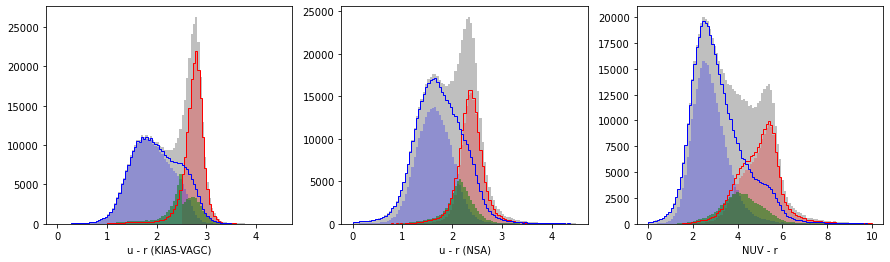

In [48]:
plt.figure(figsize=(15,4), tight_layout=True)

plt.subplot(131)

plt.hist(galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'], bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean], bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')




plt.subplot(132)

plt.hist(galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'], bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean], bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')




plt.subplot(133)

plt.hist(galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'], bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean], bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r');

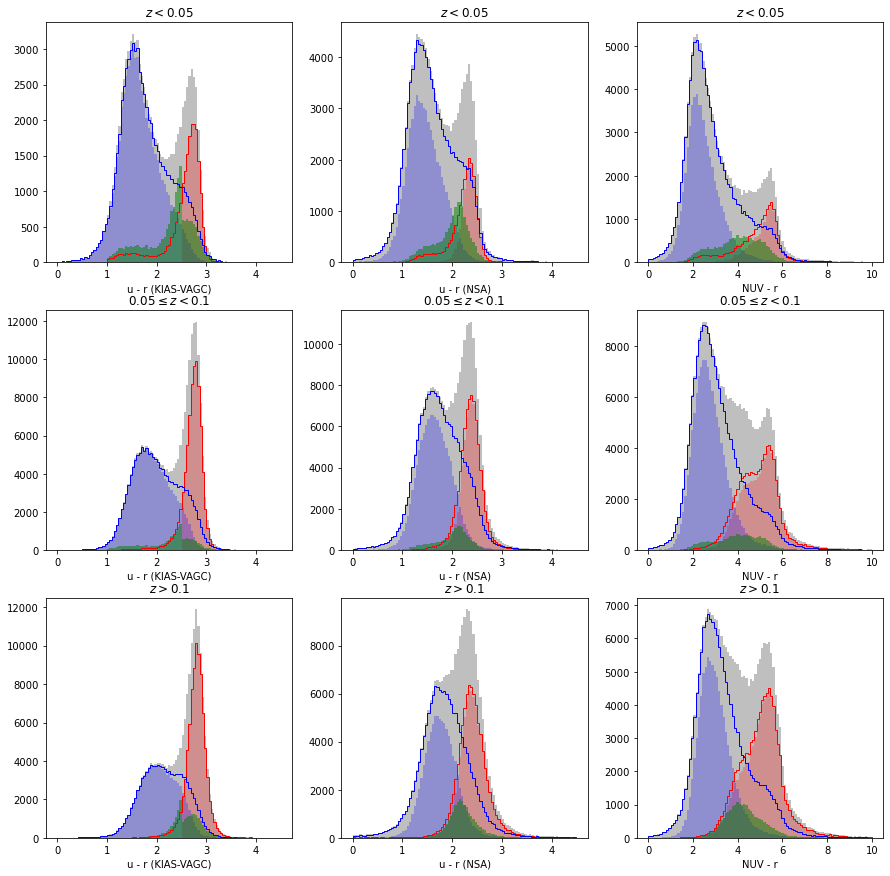

In [49]:
plt.figure(figsize=(15,15), tight_layout=True)

plt.subplot(331)

plt.hist(galaxies['u_r_KIAS'][galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'][early_galaxies['Z'] < 0.05], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean & (galaxies['Z'] < 0.05)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')

plt.title('$z < 0.05$')




plt.subplot(332)

plt.hist(galaxies['u_r'][galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'][RS_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'][BC_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'][GV_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'][early_galaxies['Z'] < 0.05], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean & (galaxies['Z'] < 0.05)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')

plt.title('$z < 0.05$')




plt.subplot(333)

plt.hist(galaxies['NUV_r'][galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'][RS_galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'][BC_galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'][GV_galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'][early_galaxies['Z'] < 0.05], 
         bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean & (galaxies['Z'] < 0.05)], 
         bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r')

plt.title('$z < 0.05$')




plt.subplot(334)

plt.hist(galaxies['u_r_KIAS'][(galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'][(GV_galaxies['Z'] < 0.05) & (GV_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'][(early_galaxies['Z'] >= 0.05) & (early_galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean & (galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')

plt.title('$0.05 \leq z < 0.1$')




plt.subplot(335)

plt.hist(galaxies['u_r'][(galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'][(GV_galaxies['Z'] < 0.05) & (GV_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'][(early_galaxies['Z'] >= 0.05) & (early_galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean & (galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')

plt.title('$0.05 \leq z < 0.1$')




plt.subplot(336)

plt.hist(galaxies['NUV_r'][(galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'][(GV_galaxies['Z'] < 0.05) & (GV_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'][(early_galaxies['Z'] >= 0.05) & (early_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean & (galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r')

plt.title('$0.05 \leq z < 0.1$')




plt.subplot(337)

plt.hist(galaxies['u_r_KIAS'][galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'][early_galaxies['Z'] >= 0.1], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean & (galaxies['Z'] >= 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')

plt.title('$z > 0.1$')




plt.subplot(338)

plt.hist(galaxies['u_r'][galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'][RS_galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'][BC_galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'][GV_galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'][early_galaxies['Z'] > 0.1], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean & (galaxies['Z'] > 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')

plt.title('$z > 0.1$')




plt.subplot(339)

plt.hist(galaxies['NUV_r'][galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'][RS_galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'][BC_galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'][GV_galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'][early_galaxies['Z'] > 0.1], 
         bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean & (galaxies['Z'] > 0.1)], 
         bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r')

plt.title('$z > 0.1$');

# Color - color gradient

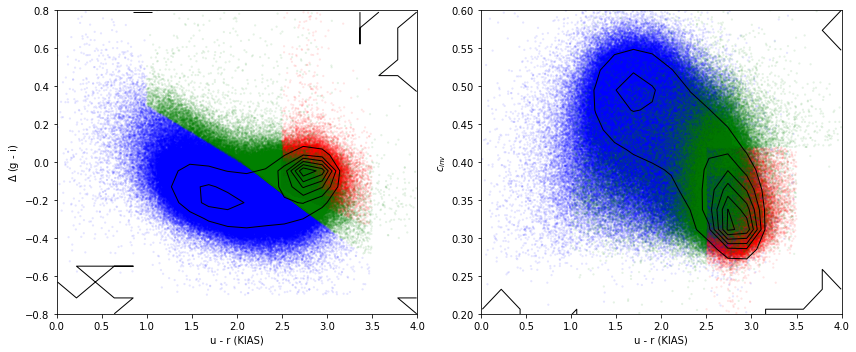

In [54]:
plt.figure(figsize=(12,5), tight_layout=True)

plt.subplot(121)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS']>=0, 
                                                   galaxies['u_r_KIAS']<=4, 
                                                   galaxies['cd']>=-0.8, 
                                                   galaxies['cd']<=0.8))]
counts,xbins,ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['cd'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'], RS_galaxies['cd'], s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'], BC_galaxies['cd'], s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'], GV_galaxies['cd'], s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(), extent=[min(xbins),max(xbins),min(ybins),max(ybins)], 
            linewidths=1, colors='black', linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')
plt.axis([0, 4, -0.8, 0.8])


plt.subplot(122)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS'] >= 0, 
                                                   galaxies['u_r_KIAS'] <= 4, 
                                                   galaxies['conx1'] >= 0.1, 
                                                   galaxies['conx1'] <= 0.6))]
counts, xbins, ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['conx1'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'], RS_galaxies['conx1'], s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'], BC_galaxies['conx1'], s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'], GV_galaxies['conx1'], s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(),
            extent=[min(xbins), max(xbins), min(ybins), max(ybins)], 
            linewidths=1, 
            colors='black', 
            linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$c_{inv}$')
plt.axis([0, 4, 0.2, 0.6]);

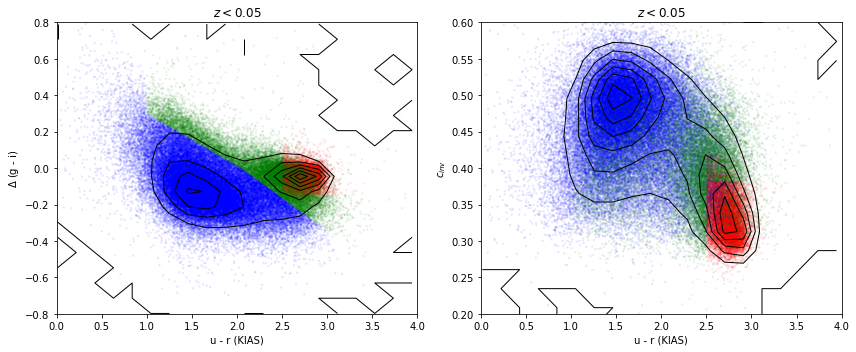

In [55]:
plt.figure(figsize=(12,5), tight_layout=True)

plt.subplot(121)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS']>=0, 
                                                   galaxies['u_r_KIAS']<=4, 
                                                   galaxies['cd']>=-0.8, 
                                                   galaxies['cd']<=0.8, 
                                                   galaxies['Z'] < 0.05))]
counts,xbins,ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['cd'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] < 0.05], 
            RS_galaxies['cd'][RS_galaxies['Z'] < 0.05], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] < 0.05], 
            BC_galaxies['cd'][BC_galaxies['Z'] < 0.05], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] < 0.05], 
            GV_galaxies['cd'][GV_galaxies['Z'] < 0.05], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(), extent=[min(xbins),max(xbins),min(ybins),max(ybins)], 
            linewidths=1, colors='black', linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')
plt.title('$z < 0.05$')
plt.axis([0, 4, -0.8, 0.8])


plt.subplot(122)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS'] >= 0, 
                                                   galaxies['u_r_KIAS'] <= 4, 
                                                   galaxies['conx1'] >= 0.1, 
                                                   galaxies['conx1'] <= 0.6, 
                                                   galaxies['Z'] < 0.05))]
counts, xbins, ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['conx1'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] < 0.05], 
            RS_galaxies['conx1'][RS_galaxies['Z'] < 0.05], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] < 0.05], 
            BC_galaxies['conx1'][BC_galaxies['Z'] < 0.05], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] < 0.05], 
            GV_galaxies['conx1'][GV_galaxies['Z'] < 0.05], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(),
            extent=[min(xbins), max(xbins), min(ybins), max(ybins)], 
            linewidths=1, 
            colors='black', 
            linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$c_{inv}$')
plt.title('$z < 0.05$')
plt.axis([0, 4, 0.2, 0.6]);

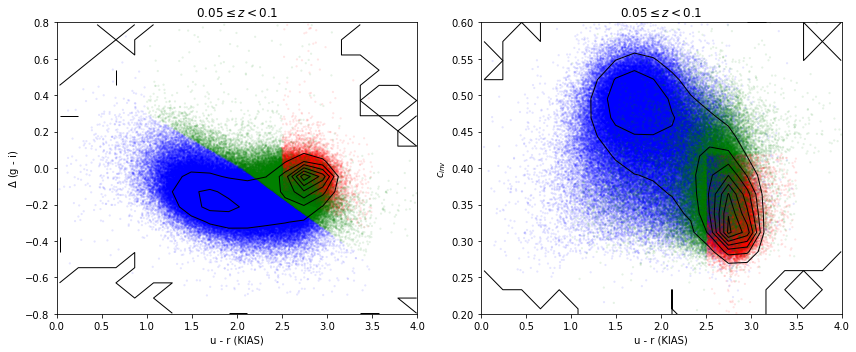

In [56]:
plt.figure(figsize=(12,5), tight_layout=True)

plt.subplot(121)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS']>=0, 
                                                   galaxies['u_r_KIAS']<=4, 
                                                   galaxies['cd']>=-0.8, 
                                                   galaxies['cd']<=0.8, 
                                                   galaxies['Z'] >= 0.05, 
                                                   galaxies['Z'] < 0.1))]
counts,xbins,ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['cd'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
            RS_galaxies['cd'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
            BC_galaxies['cd'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][(GV_galaxies['Z'] >= 0.05) & (GV_galaxies['Z'] < 0.1)], 
            GV_galaxies['cd'][(GV_galaxies['Z'] >= 0.05) & (GV_galaxies['Z'] < 0.1)], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(), extent=[min(xbins),max(xbins),min(ybins),max(ybins)], 
            linewidths=1, colors='black', linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')
plt.title('$0.05 \leq z < 0.1$')
plt.axis([0, 4, -0.8, 0.8])


plt.subplot(122)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS'] >= 0, 
                                                   galaxies['u_r_KIAS'] <= 4, 
                                                   galaxies['conx1'] >= 0.1, 
                                                   galaxies['conx1'] <= 0.6, 
                                                   galaxies['Z'] >= 0.05, 
                                                   galaxies['Z'] < 0.1))]
counts, xbins, ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['conx1'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
            RS_galaxies['conx1'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
            BC_galaxies['conx1'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][(GV_galaxies['Z'] >= 0.05) & (GV_galaxies['Z'] < 0.1)], 
            GV_galaxies['conx1'][(GV_galaxies['Z'] >= 0.05) & (GV_galaxies['Z'] < 0.1)], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(),
            extent=[min(xbins), max(xbins), min(ybins), max(ybins)], 
            linewidths=1, 
            colors='black', 
            linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$c_{inv}$')
plt.title('$0.05 \leq z < 0.1$')
plt.axis([0, 4, 0.2, 0.6]);

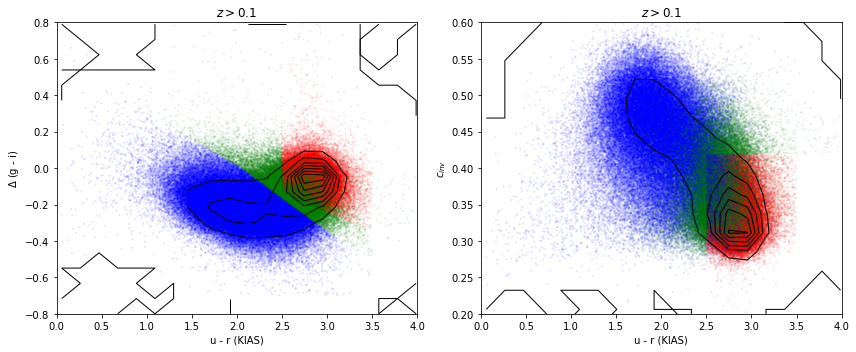

In [57]:
plt.figure(figsize=(12,5), tight_layout=True)

plt.subplot(121)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS']>=0, 
                                                   galaxies['u_r_KIAS']<=4, 
                                                   galaxies['cd']>=-0.8, 
                                                   galaxies['cd']<=0.8, 
                                                   galaxies['Z'] > 0.1))]
counts,xbins,ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['cd'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] > 0.1], 
            RS_galaxies['cd'][RS_galaxies['Z'] > 0.1], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] > 0.1], 
            BC_galaxies['cd'][BC_galaxies['Z'] > 0.1], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] > 0.1], 
            GV_galaxies['cd'][GV_galaxies['Z'] > 0.1], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(), extent=[min(xbins),max(xbins),min(ybins),max(ybins)], 
            linewidths=1, colors='black', linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')
plt.title('$z > 0.1$')
plt.axis([0, 4, -0.8, 0.8])


plt.subplot(122)
galaxies_in_plot = galaxies[np.logical_and.reduce((galaxies['u_r_KIAS'] >= 0, 
                                                   galaxies['u_r_KIAS'] <= 4, 
                                                   galaxies['conx1'] >= 0.1, 
                                                   galaxies['conx1'] <= 0.6, 
                                                   galaxies['Z'] > 0.1))]
counts, xbins, ybins = np.histogram2d(galaxies_in_plot['u_r_KIAS'], galaxies_in_plot['conx1'], bins=20)

plt.scatter(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] > 0.1], 
            RS_galaxies['conx1'][RS_galaxies['Z'] > 0.1], 
            s=5, c='r', alpha=0.1, edgecolors='none')
plt.scatter(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] > 0.1], 
            BC_galaxies['conx1'][BC_galaxies['Z'] > 0.1], 
            s=5, c='b', alpha=0.1, edgecolors='none')
plt.scatter(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] > 0.1], 
            GV_galaxies['conx1'][GV_galaxies['Z'] > 0.1], 
            s=5, c='g', alpha=0.1, edgecolors='none')
plt.contour(counts.transpose(),
            extent=[min(xbins), max(xbins), min(ybins), max(ybins)], 
            linewidths=1, 
            colors='black', 
            linestyles='solid')
plt.xlabel('u - r (KIAS)')
plt.ylabel('$c_{inv}$')
plt.title('$z > 0.1$')
plt.axis([0, 4, 0.2, 0.6]);